<h1>ANALIZA FORBESOVE LESTVICE MILJARDERJEV</h1>

In [8]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import seaborn as sns
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = 8

%matplotlib notebook
%matplotlib inline

Forbesova lestvica je mednarodno uveljavljena lestvica podjetij in posameznikov, ki se določi glede na njihovo finančno stanje in bogastvo. Je seznam najbogatejših ljudi na svetu, ki ga letno objavlja revija Forbes. Pomembno je omeniti, da obravnavana lestvica vsebuje zgolj osebe, katerih premoženje znaša 1 milijardo USD ali več.

V projektni nalogi bom analizirala Forbesovo lestvico, torej vse osebe katerih premožnje je 1 milijarda USD ali več. Podatke sem črpala s strani [Forbes](https://www.forbes.com/billionaires/), kjer lahko najdemo lestvico 2600 oseb. Za potrebe boljše analiza pa sem pridobila še podatke podatke o številu prebivalcev in BDP per capita vseh držav sveta. Slednji so bili pridobljeni s strani [World Population Review](https://worldpopulationreview.com/country-rankings/gdp-per-capita-by-country). Vsi podatki so bili zbrani oktobra 2022. 

Za vsako osebo z lestvice sem pridobila podatke o imenu, premoženju, starosti, nacionalnosti, viru dohodka ter industiji vira dohodka. Relavantni so bili vsi podatki, razen imen oseb, saj jih v ananlizi nisem nikjer uporabila. Za vsako državo sveta pa sem zajela podatke o številu prebivalcev ter BDP per capita. Zbrani tabeli sta naslednji:

Tabela Forbesove lestvice:

In [2]:
forbes = pd.read_csv(os.path.join('Obdelani-podatki/forbes.csv'))
# popravljavnje nekaterih vrednosti:
forbes['name'] = forbes.name.str.replace('&amp;', '&')
forbes['industry'] = forbes.industry.str.replace('&amp;', '&')
forbes['age'] = forbes['age'].astype('Int64')
forbes['networth'] = forbes['networth'].str.replace(r'$', '', regex=True).str.replace(r' B', '', regex=True).astype('float')
forbes

,name,networth,age,country,source,industry
0,Elon Musk,219.0,50,United States,"Tesla, SpaceX",Automotive
1,Jeff Bezos,171.0,58,United States,Amazon,Technology
2,Bernard Arnault & family,158.0,73,France,LVMH,Fashion & Retail
3,Bill Gates,129.0,66,United States,Microsoft,Technology
...,...,...,...,...,...,...
2596,Nari Genomal,1.0,82,Cyprus,apparel,Fashion & Retail
2597,Ramesh Genomal,1.0,71,Cyprus,apparel,Fashion & Retail
2598,Sunder Genomal,1.0,68,United Kingdom,garments,Fashion & Retail
2599,Horst-Otto Gerberding,1.0,69,Germany,flavors and fragrances,Food & Beverage


Tabela s podatki držav sveta:

In [3]:
drzave = pd.read_csv(os.path.join('Obdelani-podatki/worldpopulation.csv'))
# dodajanje podatkov in popravljenje imen držav:
drzave.loc[len(drzave.index)] = [47606,'St. Kitts and Nevis',18082.61]
drzave.loc[len(drzave.index)] = [36686,'Monaco',234315.46]
drzave.loc[len(drzave.index)] = [39039,'Liechtenstein',157754.95]
drzave.loc[len(drzave.index)] = [62792,'Guernsey',52300]
drzave['country'] = drzave['country'].replace({'Eswatini' :'Eswatini (Swaziland)',
                                               'Czech Republic' : 'Czechia'})
drzave

,population,country,gdp_pc
0,647599.0,Luxembourg,118001.00
1,5975689.0,Singapore,97057.00
2,5023109.0,Ireland,94392.00
3,2695122.0,Qatar,93508.00
...,...,...,...
185,47606.0,St. Kitts and Nevis,18082.61
186,36686.0,Monaco,234315.46
187,39039.0,Liechtenstein,157754.95
188,62792.0,Guernsey,52300.00


V projektni nalogi sem želela odgovoriti na naslednja vprašanja in povezave med njimi:
- Katere države iztopajo po številu milijarderjev?
- V kateri starostni skupini je največ milijarderjev?
- Kateri industriji in podjetju pripada največ oseb z lestvice?

<h3>PRIMERJAVA PREMOŽENJA</h3>

Za začetek si poglejmo kako so osebe Forbesove lestvice 'razporejene' po premoženju. 

<AxesSubplot: title={'center': 'Razkorak med milijonarji'}, xlabel='Osebe', ylabel='Premoženje [v milijardah USD]'>

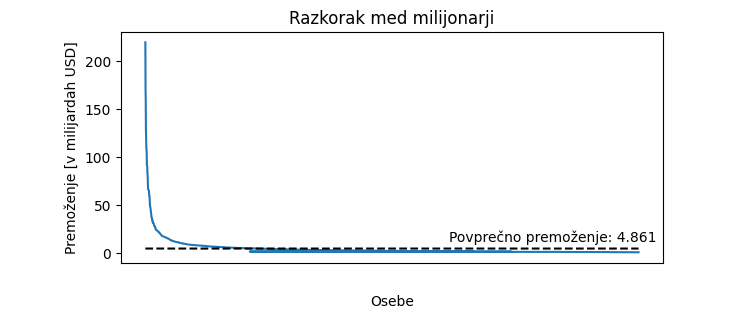

In [4]:
plt.rcParams['figure.figsize'] = [7,3]
y_mean = [forbes.networth.mean()] * len(forbes.networth) # 4.8607499999999995
fig, forbes_plot = plt.subplots()
forbes_plot.plot(forbes.name, forbes.networth, marker = '')
forbes_plot.plot(forbes.name, y_mean, linestyle = '--', color = 'black')
forbes_plot.tick_params(axis='x', colors='white')
forbes_plot.set_title('Razkorak med milijonarji')
plt.text(1600, 12, 'Povprečno premoženje: {:.3f}'.format(y_mean[0]), color = 'black')
plt.xlabel('Osebe')
plt.ylabel('Premoženje [v milijardah USD]')
forbes_plot

Z grafa je razvidno, da je razkorak med milijarderji zelo velik. Tisih, ki imajo več kot okrog 10 milijard je malo v primerjavi s številom ostalih. Povprečno premoženje oseb lestvice znaša 4.861 milijarde.

<h3>STAROSTNA STRUKTURA</h3>

Smiselno se je vprašati kakšna je struktura Forbesove lestvice, sej je pomembna za razumevanje, kako so se posamezne industrije razvijale in kako uspešne so posamezne poslovne osebe in podjetja.

Text(0.5, 0, 'Starost')

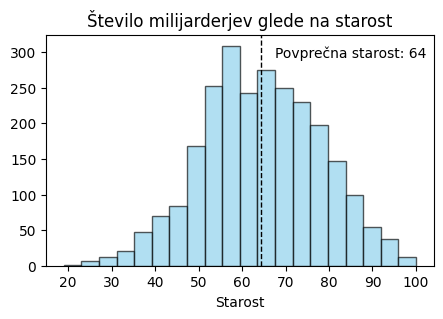

In [115]:
plt.rcParams['figure.figsize'] = [5,3]
forbes_age = forbes.age.dropna()
plot_starost = plt.hist(forbes_age, bins=20, color='skyblue', edgecolor='k', alpha=0.65)
plt.axvline(forbes_age.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(forbes_age.mean()*1.05, max_ylim * 0.9, 'Povprečna starost: {:.0f}'.format(forbes_age.mean()))
plt.rcParams["figure.figsize"] = (6,4)
plt.title('Število milijarderjev glede na starost')
plt.xlabel('Starost')

Starostno strukturo sem predstavilo s histogramom. Razberemo, da je večina milijarderjev skoncentrirana v starostni skupini med 50 in 75 leti. Povprečna starost pa je 64 let. Poglejmo si še kako se število milijarderjev spreminja glede na starost v različnih industrijah. Izbrala sem tri industrije v katerih se mi je zdelo, da se bo število oseb glede na starost znatno spreminjalo. Izbrala sem si finance in investicije, tehnologijo ter nepremičnine in dobila sem naslednji prikaz:

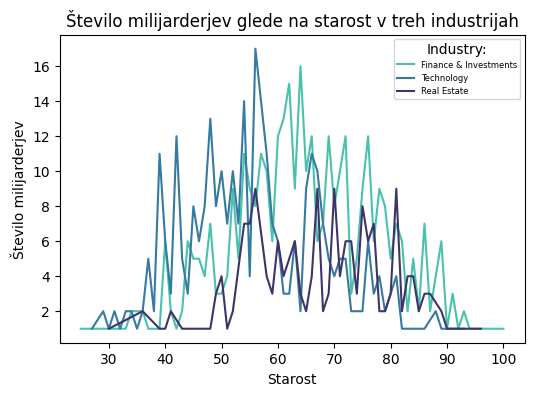

In [136]:
forbes_ind = forbes[forbes['age'].notna()]
forbes_ind = forbes_ind.loc[forbes['industry'].isin(['Finance & Investments','Technology', 'Real Estate'])].groupby(['age', 'industry']).size().reset_index(name = "stevilo")
forbes_ind['age'] = forbes_ind['age'].astype('int64')
palette = sns.color_palette("mako_r", 3)
sns.lineplot(data = forbes_ind, x = 'age', y = 'stevilo', hue = 'industry', palette = palette)
plt.title('Število milijarderjev glede na starost v treh industrijah')
plt.xlabel('Starost')
plt.ylabel('Število milijarderjev')
plt.legend(title='Industry:')

Z grafa lahko razberemo, da je večina milijarderjev v tehnologiji mlajših od 60 let. To si razlagam s hitrim ravojem in spremembami v panogi. V tehnologiji so prav tako zaželjene nove ideje, kreativnost, ustvarjalnost in inovacije, kar privlači mlade osebe, ki so odraščale v digitalni dobi. Večina milijarderjev v financah je v starosti med 60 in 70 let. V nepremičninah pa so očitno najuspešnejši starejši od 55, saj so imeli več časa, da so zgradili svoje premoženje in izkoristili priložnosti na trgu nepremičnin. 

Mlajši posamezniki lestvice nam kažejo pomembno budnega okolja, ki spodbuja inovacije in nove načine poslovanja. Na drugi strani pa nam starejša podjetja in posamezniki na lestvici kažejo na trdne temelje in stabilnost ter dolgoročne uspešnosti.

Naprej se lahko vprašamo kako se glede na starost spreminja premoženje.

<h3>PREMOŽENJE GLEDE NA STAROST</h3>

V naslednjem prikazu sem predstavila spreminjanje premoženja v odvisnosti od starosti. Za vsako starost sem vzela povprečje premoženj in dobila naslednji graf:

Text(0.5, 0, 'Premoženje v milijardah USD')

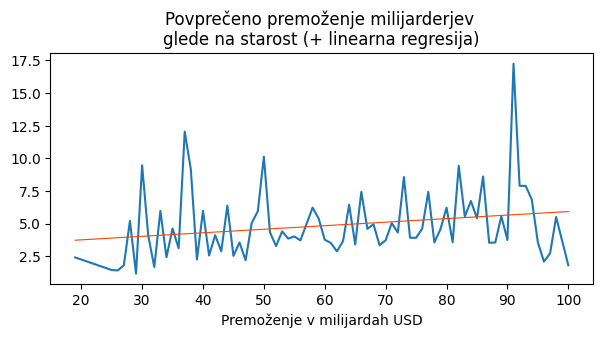

In [21]:
forbes_age_r = forbes.groupby('age')['networth'].mean().reset_index(name = "povprecje")
forbes_age_r
X = forbes_age_r.iloc[:, 0].values.reshape(-1, 1)  # iloc[:, 1] is the column of X
Y = forbes_age_r.iloc[:, 1].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
forbes_networth_age_plot = forbes_age_r.plot(x = 'age', y = 'povprecje', legend = False)
forbes_networth_age_plot.plot(X, Y_pred, color = 'orangered', lw = 0.8)
forbes_networth_age_plot.set_title('Povprečeno premoženje milijarderjev \nglede na starost (+ linearna regresija)')
forbes_networth_age_plot.set_xlabel('Starost')
forbes_networth_age_plot.set_xlabel('Premoženje v milijardah USD')

Opazimo, da se povprečno premoženje s starostjo v grobem malo veča, vendar povezava med premoženjem in starostjo ni jasno razvidna. 

<h3>NACIONALNOST</h3>

Naprej sem se odločila, da pogledam katera nacionalnost je po številu najbolj izstopajča. Najprej si poglejmo tabelo, ki nam pove koliko milijarderjev je v posamezni državi:

In [24]:
forbes.groupby("country").size().reset_index(name = "st_milijarderjev").sort_values(by = "st_milijarderjev", ascending = False)

,country,st_milijarderjev
70,United States,719
11,China,515
28,India,161
22,Germany,130
...,...,...
17,Estonia,1
6,Belize,1
4,Barbados,1
74,Zimbabwe,1


Največ milijarderjev je torej v ZDA, sledita pa ji Kitajska in Indija. Te številke nam res povedo, v kateri državi je največ najbogatejših, vendar je bolj smiselno, da gledamo število milijarderjev glede na število prebivalcev države, morda glede na BDP države in podobno. Slednje sem tudi naredila in prikazala z različnimi grafičnimi prikazi. 

Najprej si poglejmo število milijarderjev glede na število prebivalcev posamezne države.

Priprava in združevanje podatkov držav:

In [26]:
forbes['country_n'] = forbes['country'].replace({'Eswatini (Swaziland)' :'eSwatini',
                                                                   'Guernsey' : 'United Kingdom',
                                                                   'Hong Kong' : 'China',
                                                                   'Monaco' : 'France',
                                                                   'Singapore' : 'Malaysia',
                                                                   'St. Kitts and Nevis' : 'United Kingdom',
                                                                   'United States' : 'United States of America',
                                                                   'Barbados' : 'United Kingdom'})
drzave['country_n'] = drzave['country'].replace({'Eswatini' :'eSwatini',
                                               'Guernsey' : 'United Kingdom',
                                               'Hong Kong' : 'China',
                                               'Monaco' : 'France',
                                               'Singapore' : 'Malaysia',
                                               'St. Kitts and Nevis' : 'United Kingdom',
                                               'United States' : 'United States of America',
                                               'Barbados' : 'United Kingdom'})
forbes_countries = forbes.groupby("country_n").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country_n')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']

Odločila sem se, da rezultate prikažem na zemljevidu, vendar ta prikaz ni najbolj realen, saj že vgrajen zemljevid sveta ne vsebuje vseh držav in sicer ravno držav, ki so v tej analizi najbolj relavantne. Vsebuje ne npr. Monaca, Singapurja, Hong Konga ter nekaterih članic Skupnosti narodov (The Commonwealth), ki vemo, da so dom zelo vplivnih in premožnih oseb. Slednje države sem zato pripisala najbolj smiselnim državam, npr. Monaco Franciji, članice Skupnosti narodov Veliki Britaniji, Hong Kong Kitajski, Singapur pa Maleziji.

Za prikaz podatkov sem uporabila knjižnico Folium, ki omogoča enostavno ustvarjanje interaktivnih zemljevidov in vizualizacije geografskih podatkov.

In [27]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename({'name': 'country_n'}, axis = 1)
world = pd.merge(world, forbes_countries, how='left', on='country_n')

custom_scale = (world['forbes_na_preb'].quantile((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))).tolist()
map = folium.Map()
zemljevid = folium.Choropleth(
    geo_data = world,
    name = 'choropleth',
    data = world,
    columns = ['country_n', 'forbes_na_preb'],
    key_on = 'feature.properties.country_n',
    threshold_scale = custom_scale,
    fill_color = 'YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend = False,
    nan_fill_color = 'white'
    ).add_to(map)
for key in zemljevid._children:
    if key.startswith('color_map'):
        del(zemljevid._children[key])   
zemljevid.add_to(map)
map

<p style="color:deepskyblue;"><b>Tem bolj je država na zemljevidu temne barve, tem več milijarderjev na število prebivalcev ima.</b></p>

Z zemljevida razberemo, da je naveč milijarderjev v Franciji, Veliki Britaniji, Francoski Gvajani, skandinaviji, ZDA, Kanadi ter Avstraliji. Seveda pa to ni nujno res, zaradi prej opisanega problema priključevanja manjših držav večjim. 

Zaradi slednjega problema, sem se odločila, da podatke prikažem še z enostavnim stolpičnim grafom. Spodaj sta dva stolpična grafa; prvi prikazuje število milijarderjev glede na število prebivalcev po državah, drugi pa število milijarderjev glede na BDP posamezne države. 

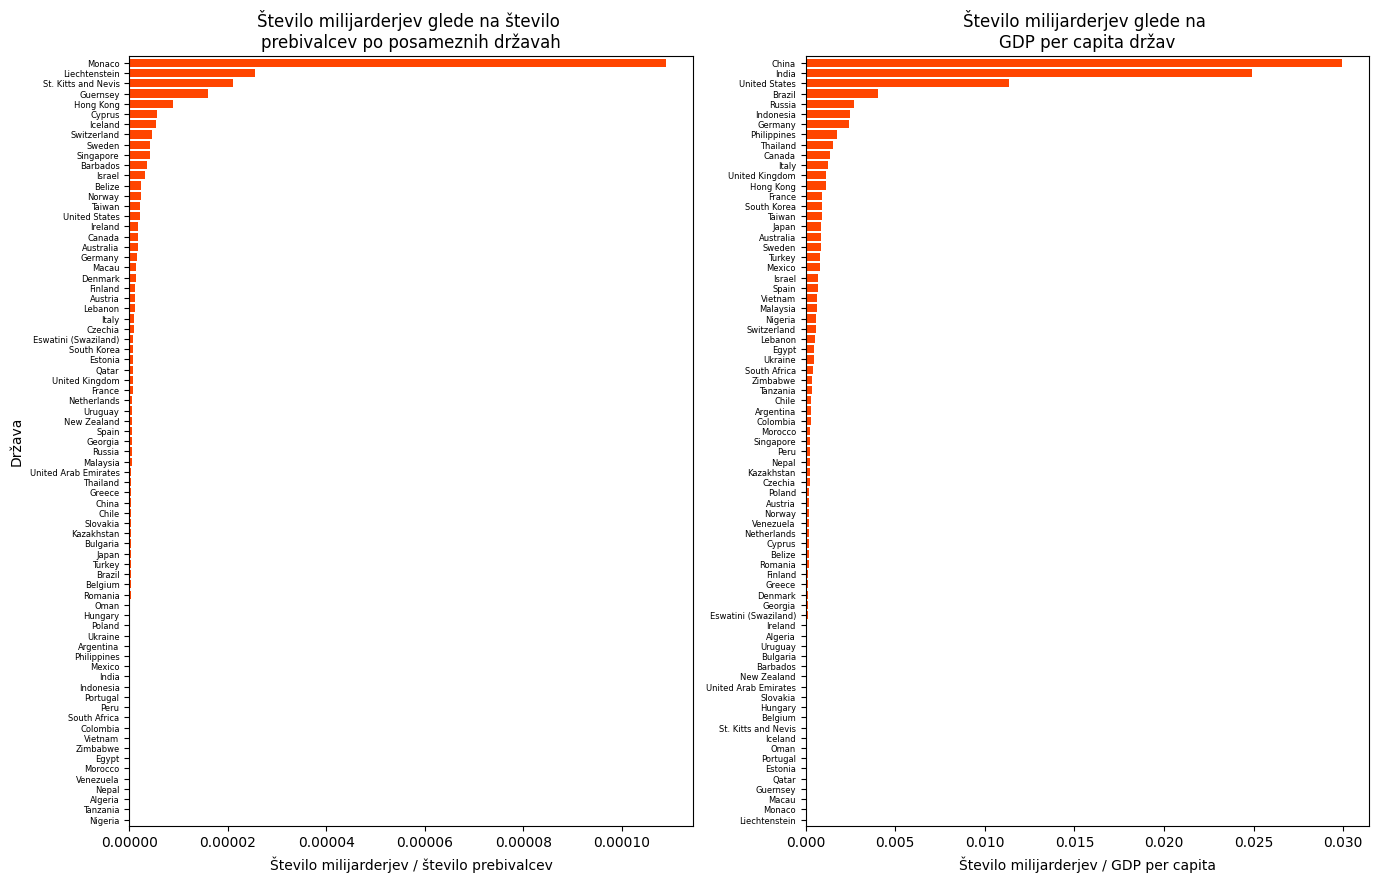

In [28]:
forbes_countries = forbes.groupby("country").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']

forbes_countries_gdp = forbes.groupby("country").size().reset_index(name = "forbes_count")
forbes_countries_gdp = pd.merge(forbes_countries_gdp, drzave, how='left', on='country')
forbes_countries_gdp['forbes_gdppc'] = forbes_countries_gdp['forbes_count'] / forbes_countries_gdp['gdp_pc']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

forbes_countries_plot = forbes_countries.sort_values(by = 'forbes_na_preb', ascending = True).plot.barh(x = 'country', y = 'forbes_na_preb', 
                legend = False, ax = ax1, figsize = (16, 10), width = 0.8, color = 'orangered')
forbes_countries_plot.set_xlabel("Število milijarderjev / število prebivalcev")
forbes_countries_plot.set_ylabel("Država")
forbes_countries_plot.set_title("Število milijarderjev glede na število \nprebivalcev po posameznih državah")

forbes_countries_gdp_plot =forbes_countries_gdp.sort_values(by = 'forbes_gdppc', ascending = True).plot.barh(x = 'country', y = 'forbes_gdppc', 
                legend = False, ax = ax2, figsize = (16, 10), width = 0.8, color = 'orangered')
forbes_countries_gdp_plot.set_xlabel("Število milijarderjev / GDP per capita")
forbes_countries_gdp_plot.set_ylabel(" ")
forbes_countries_gdp_plot.set_title('Število milijarderjev glede na \nGDP per capita držav')

for ax in (ax1, ax2):
    ax.tick_params(axis = 'y', which = 'both', labelsize = 6)

Obravnavajmo prvi prikaz. Po številu milijarderjev glede na število prebivalcev države izstopajo ravno nekatere izmed držav, ki so nam pri zemljevidu predstavljaje težave. V vrhu so Monaco, Lihtenštajn, Sveti Krištof in Nevis, Guernsey in Hong Kong. Torej gre v večini za žepne države. Na zemljevidu sta med drugimi izstopala Francija in Velika Britanija, z zgornjega prikaza pa opazimo, da nista ravno v vrhu lestvice. Izstopali sta torej zgolj zaradi priključitve drugih, manjših držav.

Na drugem grafu - pri obravnavi števila milijarderjev glede na BDP per capita - so najboljše Kitajska, Indija, ZDA, Brazilija ter Rusija. Če se spomnimo prvotne tabele, ji je ta razvrstitev veliko bolj podobna. Sklepali bi torej lahko, da sta BDP per capita in število milijarderjev povezana - da visok BDP per capita, pomeni višji dohodek prebivalcev, kar vodi v večjo verjetnost, da so med njimi tudi milijarderji. Seveda pa to ni edini dejavnik, ki lahko vpliva na število milijarderjev v državi. Med drugim vpliva tudi npr. fiskalne politika, stabilnost gospodarstva, raven korupcije in videli bomo da tudi število prebivalec. Obstajajo države z visokim BDP per capita, a majhnim številom milijarderjev, in države z nižjim BDP per capita, a večjim številom milijarderjev. Trdimo lahko, da v grobem obstaja povezava med BDP per capita in številom milijarderjev, neposrednega razmerja med njima pa ni.

Poglejmo si povezavo BDP per capita in številom milijarderjev:

Text(0, 0.5, 'Število milijarderjev')

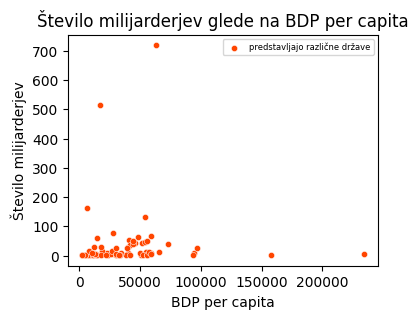

In [37]:
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams.update({'legend.fontsize': 6})
sns.scatterplot(x = forbes_countries.gdp_pc, y = forbes_countries.forbes_count, label = 'predstavljajo različne države', legend = True, color = 'orangered', s = 20)
plt.title('Število milijarderjev glede na BDP per capita')
plt.xlabel('BDP per capita')
plt.ylabel('Število milijarderjev')

BDP per capita in število milijarderjev seveda nista v linearnem razmerju. V grafu izstopajo predvsem države z največ milijarderji, iz tabele lahko preberemo, da so to ZDA, Indija in Kitajska, ki pa nimajo največjega BDP per capita. Spodnja desna pika je Monaco, ki ima največji BDP per capita, kar 234315 USD. Po prejšnjem razmišljanju bi moral imeti Monaco več kot 700 milijarderjev (če ga primerjamo z ZDA), kar je nerealno, saj je njegova pupulacija manj kot 40 tisoč oseb.
Torej povezava med BDP per capita in številom milijarderjev ni razvidna.

Na hitro si šoglejmo še povezavo med BDP per capita in številom milijarderjev glede na število prebivalcev države:

Text(0, 0.5, 'Število milijarderjev \nna število prebivalcev')

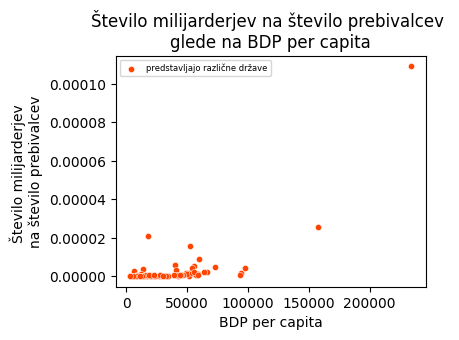

In [38]:
sns.scatterplot(x = forbes_countries.gdp_pc, y = forbes_countries.forbes_na_preb, label = 'predstavljajo različne države', legend = True, color = 'orangered', s = 20)
plt.title('Število milijarderjev na število prebivalcev \nglede na BDP per capita')
plt.xlabel('BDP per capita')
plt.ylabel('Število milijarderjev \nna število prebivalcev')

Ponovno pridemo do sklepa, da jasne povezave med številom milijarderjev na število prebivalcev in BDP per capita ni. Morda je slednja povezava bolj občitna če bi opazovali tudi milijonarje.

<h3>20 DRŽAV Z V POVPREČJU NAJBOLJ PREMOŽNIMI</h3>

Za vsako državo naredimo povprečno premoženje milijarderjev in vzmemo 20 držav z največjim povprečnim premoženjem. Za opisano sem naredila diagram kvartilov za vsako od izbranih držav:

Text(0.5, 1.0, 'Prvih 20 držav, katerih milijarderji imajo v povprečju največ')

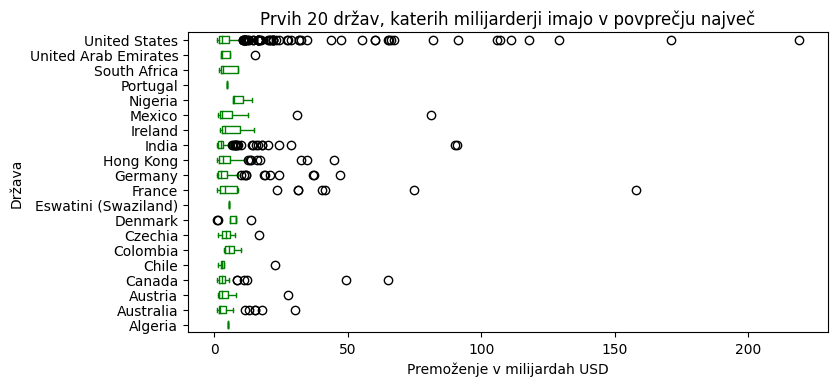

In [42]:
plt.rcParams['figure.figsize'] = [8,4]
povprecje = forbes.groupby('country')['networth'].mean().sort_values(ascending = False).reset_index(name = "povprecje")
povprecje = povprecje.head(20).sort_values('country', ascending = False)
forbes_nw = forbes.loc[forbes['country'].isin(povprecje.country.values.tolist())]
forbes_networth_na_drzavo_plot = forbes_nw.boxplot(by = 'country', column = ['networth'], grid = False, vert = False, color = 'green')
plt.title('')
plt.suptitle('')
# plt.plot(povprecje.povprecje, povprecje.country)
forbes_networth_na_drzavo_plot.set_xlabel("Premoženje v milijardah USD")
forbes_networth_na_drzavo_plot.set_ylabel("Država")
forbes_networth_na_drzavo_plot.set_title('Prvih 20 držav, katerih milijarderji imajo v povprečju največ')

Z grafa opazimo, da imajo obravnavane države zelo podobno vrednost medijane in spodje vrednosti.

<h3>INDUSTRIJA</h3>

Poglejmo si kako so milijarderji razporejeni glede na industrijo vira prihodka. Slednje sem prikazala s tortnim diagramom:

<AxesSubplot: title={'center': 'Miljarderji glede na industrijo vira prihodka'}>

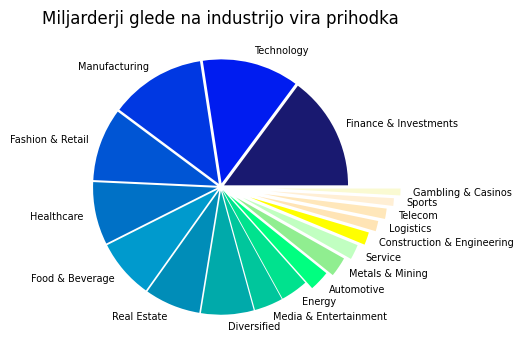

In [43]:
plt.rcParams['figure.figsize'] = [4,5]
colors = ['#191970', '#001CF0','#0038E2', '#0055D4', '#0071C6', '#009ACD', '#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80', '#90EE90','#C1FFC1','#FFFF00', '#FFE4B5', '#FFE7BA', '#FFEFD5', '#FAFAD2']
forbes.groupby('industry').size().sort_values(ascending = False).plot.pie(
    explode = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45),
    colors = colors,
    title = 'Miljarderji glede na industrijo vira prihodka',
    textprops={'fontsize': 7})

Z diagrama je razvidno, da je največ milijarderjev v financah in investicijah ter tehnologiji. Slednji industriji kot znano omogočata visoke dobičke in hitro rast premoženja. Zanimivo se mi zdi, da se energetika ni uvrstila višje. To si razlagam z dejstvom, da je verjetno na seznamu veliko oseb, ki so del energatike, ampak to ni njihov glavni, navečji vir dohodka.

Naprej si poglejmo povprečno premoženje glede na industijo:

Text(0, 0.5, 'Industrija')

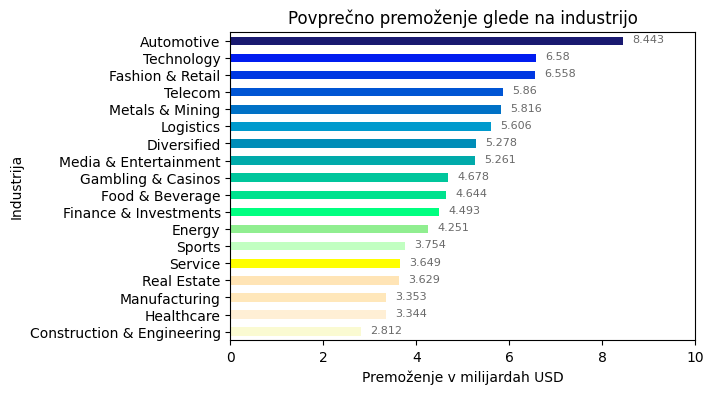

In [44]:
plt.rcParams['figure.figsize'] = [6,4]
forbes_ind = forbes.groupby("industry")["networth"].mean().round(3).sort_values(ascending = True).reset_index(name = "povprecje").plot.barh(x = 'industry', y = 'povprecje', color = colors[::-1], legend = False)
for i in forbes_ind.patches:
    forbes_ind.text(i.get_width()+.2, i.get_y()+.15, \
            i.get_width(), fontsize=8, color='dimgrey')
forbes_ind.set_title('Povprečno premoženje glede na industrijo')
forbes_ind.set_xlim(0, 10)
forbes_ind.set_xlabel("Premoženje v milijardah USD")
forbes_ind.set_ylabel("Industrija")

Največje povprečno premoženje pripada avtomobilski industriji, sledijo pa ji tehnologija ter moda. Zgornji razvrstitvi sta torej precej različni. Torej največja industrija ni nujno najbolj dobičkonosna. Omenila bi, da avtomobilni industriji pripada prva oseba lestvice, Elon Musk, kar seveda znatno vpliva na večje povprečno premoženje. 

<h3>PODJETJA</h3>

Nazadnje obravnavajmo še glavni vir dohodka posameznikov s seznama. Za bolj jasno/ravidno analizo sem izbrala samo vire dohodka, ki so skupni več kot devetim milijarderjem in dobila sem naslednji prikaz:

<AxesSubplot: title={'center': 'Glavni viri prihodka za več kot 9 milijarderjev'}, xlabel='Glavni vir prihodka', ylabel='Število miljarderjev'>

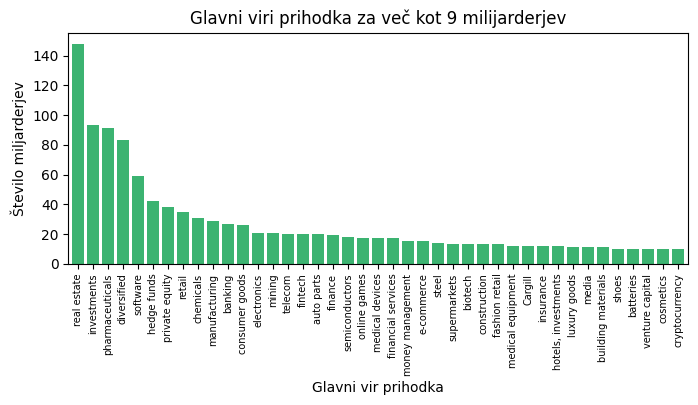

In [45]:
plt.rcParams['figure.figsize'] = [8,3]
forbes_source = forbes.groupby('source').size().sort_values(ascending = False).reset_index(name = "num")
forbes_source_plot = forbes_source[forbes_source.num > 9].plot.bar(x = 'source', y = 'num', legend = False, color = 'mediumseagreen', width = 0.8)
forbes_source_plot.set_xlabel("Glavni vir prihodka")
forbes_source_plot.set_ylabel("Število miljarderjev")
forbes_source_plot.set_title('Glavni viri prihodka za več kot 9 milijarderjev')
forbes_source_plot.set_xticklabels(forbes_source[forbes_source.num > 9].source, rotation = 90, fontsize = 7)
forbes_source_plot

Če pogledamo vse vire prihodka v prikazu ugotovimo, da jih je zelo veliko povezanih s financami. Torej so investicije in finance edn glavnih virov prihodka večine najbogatejših. Kot glavni vir prihodka na prikazu izstopajo nepremičnine, sledijo pa investicije in farmacevtska dejavnost. 

Poglejmo si nepremičnine in investicije malo pobliže in sicer po državah:

<AxesSubplot: title={'center': 'Nepremičnine in investicije kot vir prihodka po državah'}, xlabel='Država', ylabel='Število miljarderjev'>

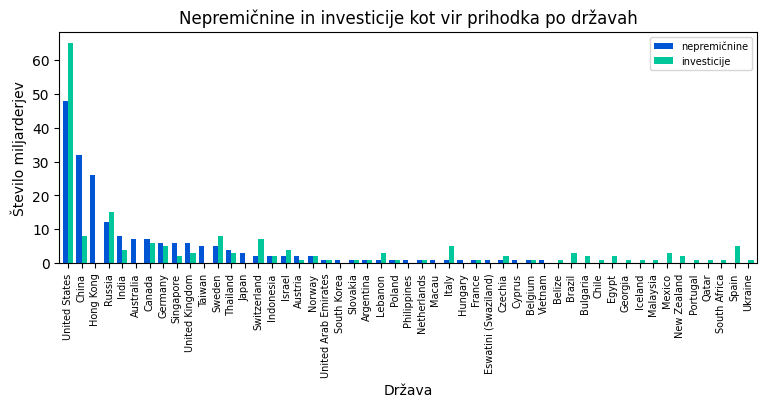

In [102]:
plt.rcParams['figure.figsize'] = [9,3]
realestate = forbes[forbes.source.str.contains('real estate')].groupby("country").size() 
investments = forbes[forbes.source.str.contains('investments')].groupby("country").size() 
forbes_re_i = pd.concat([realestate, investments], axis = 1, sort = False).rename(index = str, columns={0: "real estate", 1: "investments"}).sort_values('real estate', ascending = False)
forbes_re_i_plot = forbes_re_i.plot.bar(width = 0.75, color = ['#0055D4', '#00C69C'])
forbes_re_i_plot.set_title('Nepremičnine in investicije kot vir prihodka po državah')
forbes_re_i_plot.set_xlabel("Država")
forbes_re_i_plot.set_ylabel("Število miljarderjev")
forbes_re_i_plot.set_xticklabels(forbes_re_i.index, rotation = 90, fontsize = 7)
forbes_re_i_plot.legend(["nepremičnine", "investicije"], fontsize = 7)
forbes_re_i_plot

Z grafa najbolj izstopa ZDA, tako s številom posameznikov v nepremičninah, kot tudi investicijah. V obeh pogledih izstopa tudi Rusija. Pomembno vlogo nepremičnin opazimo tudi na Kitajskem (in Hong Kongu). Razvidno je, da je več obravanih posameznikov povezanih z investicijami, kot nepremičninami. Torej so investicije in finance, res en glavnih virov prihodka oseb lestvice.

<h3>ZAKLJUČEK</h3>

Povzamimo glavne ugotovitve analize. Ugotovili smo, da je razkorak med osebami lestvice velik (zelo malo je tistih, ki imajo premoženje več kot okrog 10 milijard USD). Povprečno premoženje znaša malo manj kot 5 milijard USD. Največ posameznikov lestivce je starih med 50 in 75 let in starostna sestava pripadnikov različnih industrij je zelo različna. Največ oseb z lestvice pripada industriji finance in investivice, sledita pa tehnologija in trgovina. Največje povprečno premoženje ima avtomobilska industrija, med drugim tudi zato ker jih pripada najbogateša oseba lestvice. Če opazujemo države glede na število milijarderjev na število prebivalcev zelo izstopa Monaco sledijo pa druge, prav tako žepne države in sicev Lihtenštajn, Sveti Krištof in Nevis, Guernsey in Hong Kong. Z različnimi grafičnimi prikazi sem potrdila tudi, da jasne povezave med številom milijarderjev in BDP per capita ni ter da so investicije in finance en glavnih viro prihodka oseb lestvice.